# check support for $p(\theta_g\,|\,M_u, M_g, M_r, M_i, M_z, \sigma_u, \sigma_g, \sigma_r, \sigma_i, \sigma_z)$

In [1]:
import os
import h5py 
import numpy as np

In [2]:
from astropy.table import Table

In [3]:
from goleta import data as D

In [4]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## load NASA-Sloan Atlas

In [5]:
Xs = D.get_obs(cut='v1')

23207 observed galaxies


/home/chhahn/projects/goleta/src/goleta/data.py:143: RuntimeWarning: divide by zero encountered in power
  sigmag_nsa = ivar_absmag_nsa**-0.5


In [6]:
absmag_nsa = Xs[:,:5]
sigmag_nsa = Xs[:,5:]

## load CAMELS-TNG

In [7]:
_, Xs = D.get_data('all', 'omega', 'xobs', sim='tng', downsample=True)

/home/chhahn/projects/goleta/src/goleta/data.py:39: RuntimeWarning: divide by zero encountered in log10
  props[:,6] = np.log10(props[:,6]) # log Mgas


In [8]:
absmag_camels = Xs[:,:5]
sigmag_camels = Xs[:,5:]

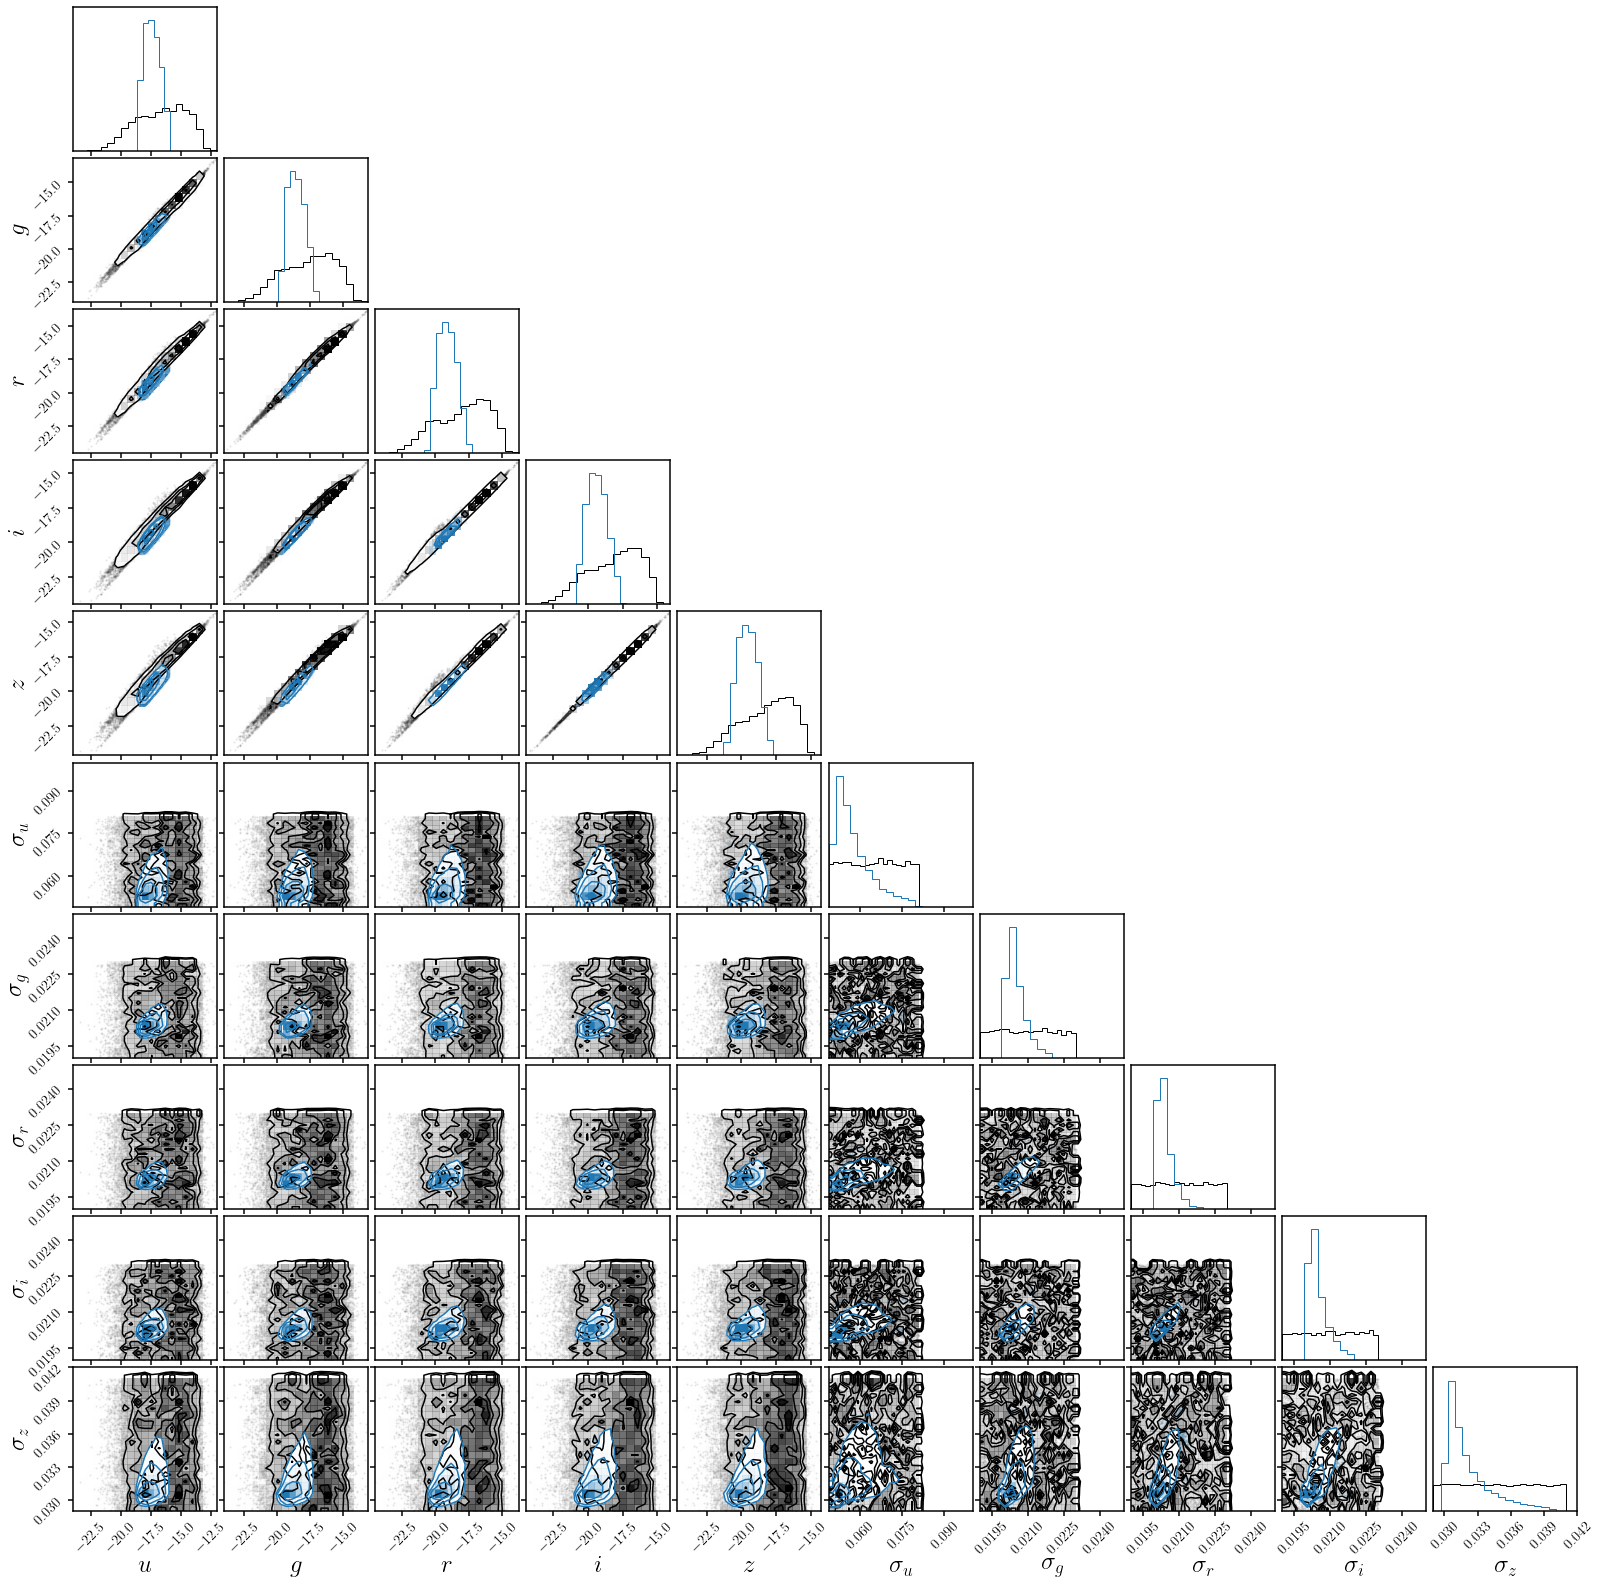

In [11]:
fig = DFM.corner(np.concatenate([absmag_camels, sigmag_camels], axis=1)[::10], color='k', 
                hist_kwargs={'density': True})
_ = DFM.corner(np.concatenate([absmag_nsa, sigmag_nsa], axis=1), color='C0', 
               hist_kwargs={'density': True},
               range=[(-24, -15) for i in range(5)] + [(0.049, 0.1)] + [(0.019, 0.025) for i in range(3)] + [(0.029, 0.042)],
               labels=[r'$%s$' % b for b in ['u', 'g', 'r', 'i', 'z']] + [r'$\sigma_u$', r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
               label_kwargs={'fontsize': 25}, 
               fig=fig)

In [15]:
colors_nsa, colors_camels, lbls = [], [], []
for i in range(5): 
    for j in range(5): 
        if i < j: 
            colors_nsa.append(absmag_nsa[:,i] - absmag_nsa[:,j])
            colors_camels.append(absmag_camels[:,i] - absmag_camels[:,j])
            lbls.append(r'$%s - %s$' % (['u', 'g', 'r', 'i', 'z'][i], ['u', 'g', 'r', 'i', 'z'][j]))
colors_nsa = np.array(colors_nsa).T
colors_camels = np.array(colors_camels).T

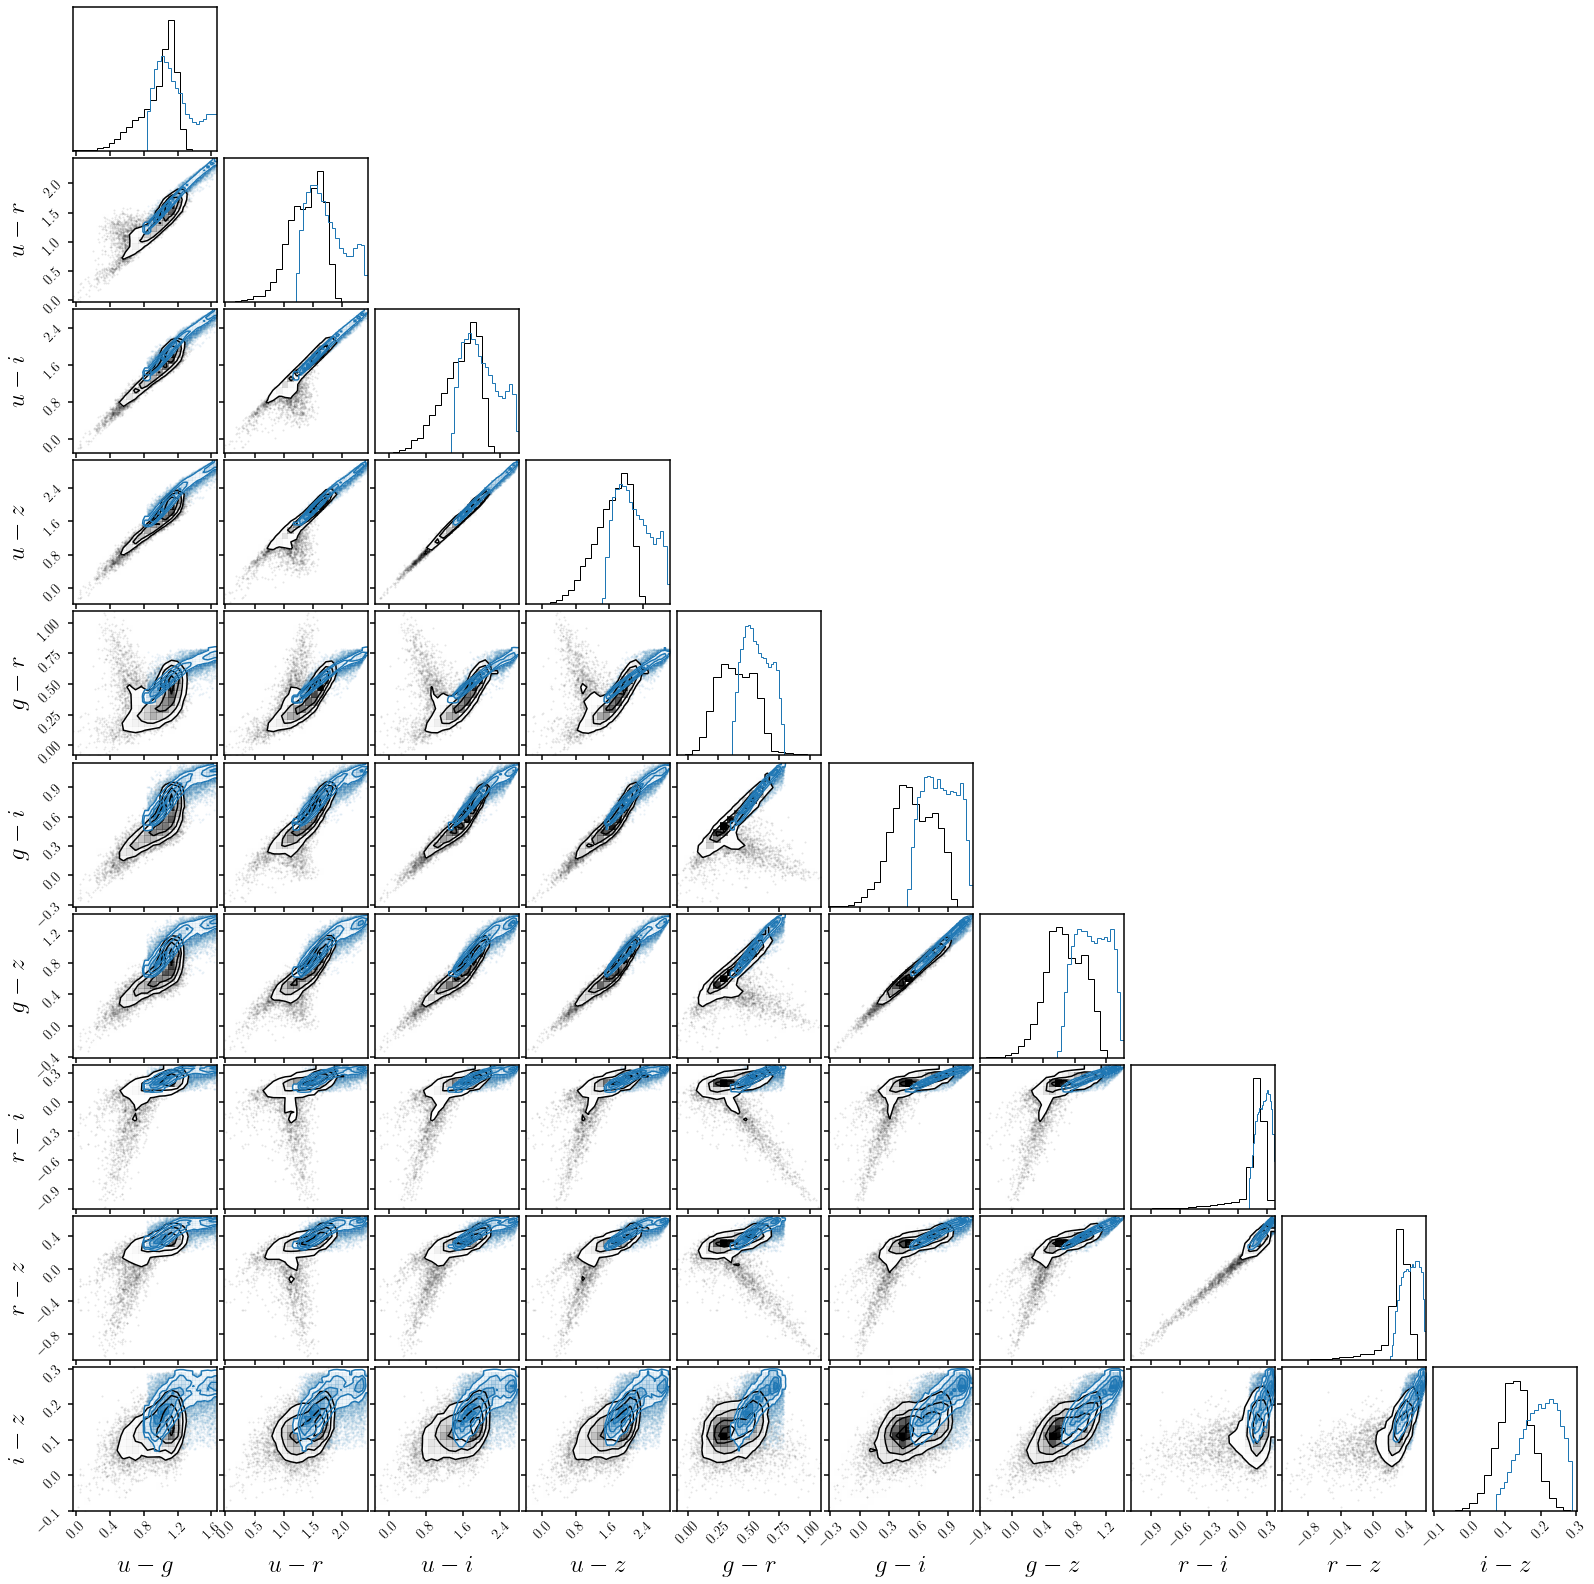

In [17]:
fig = DFM.corner(colors_camels[::10], color='k', 
                hist_kwargs={'density': True})
_ = DFM.corner(colors_nsa, color='C0', 
               hist_kwargs={'density': True},
               #range=[(-0.5, 1) for i in range(colors_nsa.shape[1])],
               labels=lbls, label_kwargs={'fontsize': 25}, 
               fig=fig)

In [13]:
cuts_absmag = np.ones(absmag_nsa.shape[0]).astype(bool)
for i in range(4): 
    cuts_absmag = cuts_absmag & (absmag_nsa[:,i] < -16) & (absmag_nsa[:,i] > -20.)

## check colors $g-r, r-i, i-z$, ...

In [14]:
colors_camels = np.array([absmags_camels[:,0] - absmags_camels[:,1], 
                           absmags_camels[:,0] - absmags_camels[:,2],
                           absmags_camels[:,0] - absmags_camels[:,3],
                           absmags_camels[:,1] - absmags_camels[:,2],
                           absmags_camels[:,1] - absmags_camels[:,3],
                           absmags_camels[:,2] - absmags_camels[:,3]]).T
colors_nsa = np.array([absmag_nsa[:,0] - absmag_nsa[:,1], 
                         absmag_nsa[:,0] - absmag_nsa[:,2], 
                         absmag_nsa[:,0] - absmag_nsa[:,3], 
                         absmag_nsa[:,1] - absmag_nsa[:,2], 
                         absmag_nsa[:,1] - absmag_nsa[:,3],
                         absmag_nsa[:,2] - absmag_nsa[:,3]]).T

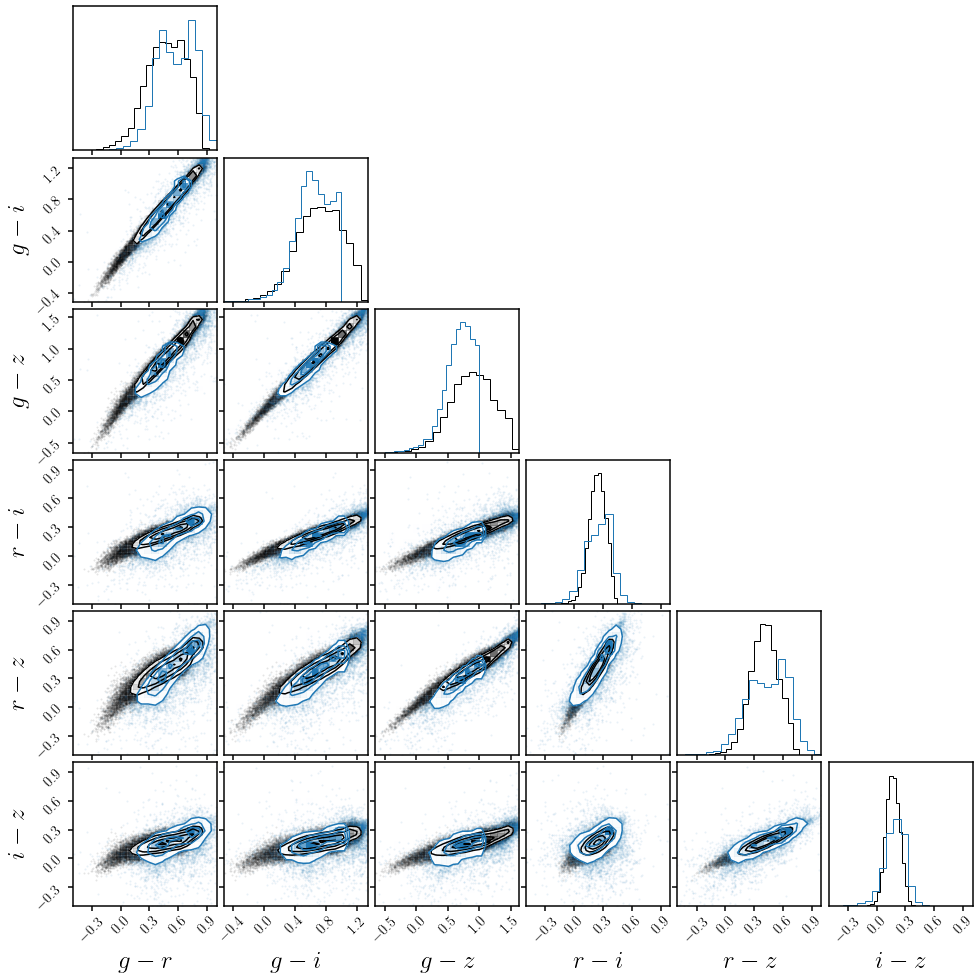

In [15]:
fig = DFM.corner(colors_camels[::10], color='k', 
                hist_kwargs={'density': True})
_ = DFM.corner(colors_nsa[::10], color='C0', 
               hist_kwargs={'density': True},
               range=[(-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1)],
               labels=['$g-r$', '$g-i$', '$g-z$', '$r-i$', '$r-z$', '$i-z$'],
               label_kwargs={'fontsize': 25}, 
               fig=fig)

In [16]:
color_lims = np.quantile(colors_camels, [0.16, 0.84], axis=0)

In [22]:
print(color_lims)

[[0.26391692 0.42210869 0.53792424 0.15047391 0.26251017 0.09671507]
 [0.68782795 1.00967182 1.23166971 0.329177   0.55766533 0.2415818 ]]


In [17]:
cuts_color = np.ones(len(colors_nsa)).astype(bool)
for icolor in range(color_lims.shape[1]): 
    cuts_color = (cuts_color & 
                  (colors_nsa[:,icolor] > color_lims[0,icolor]) & 
                  (colors_nsa[:,icolor] < color_lims[1,icolor]))

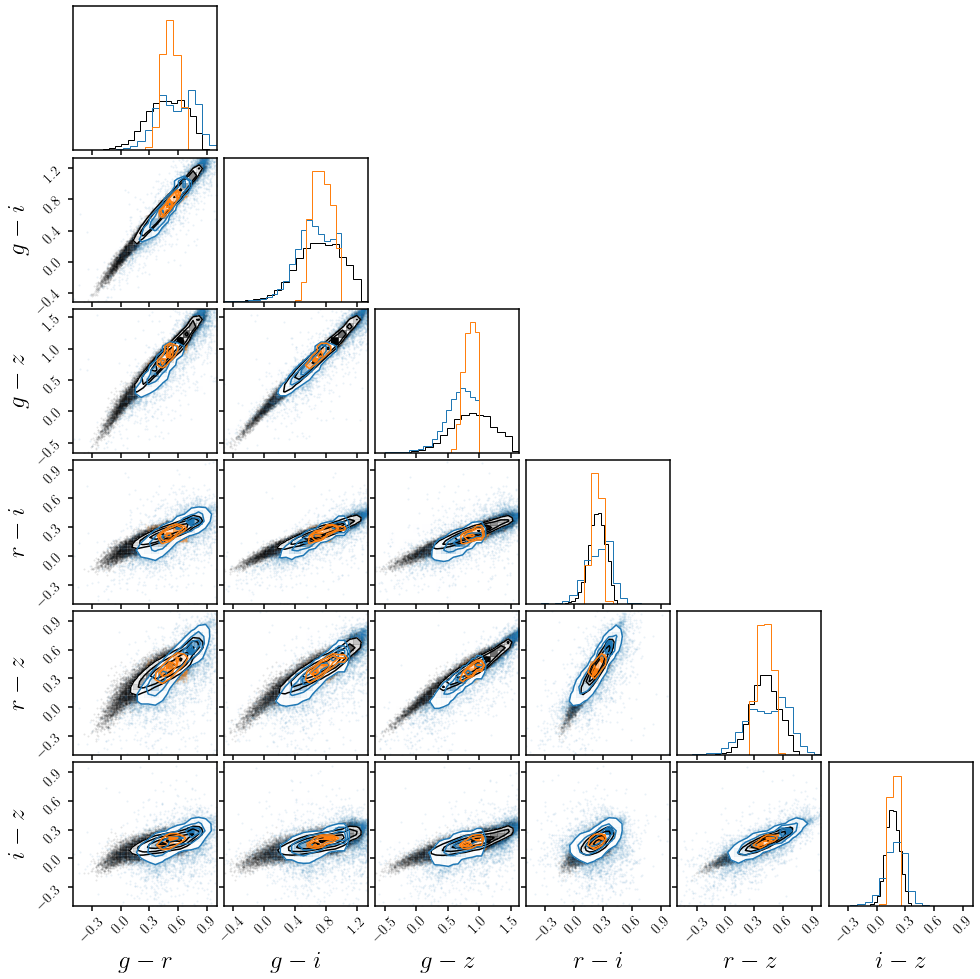

In [18]:
fig = DFM.corner(colors_camels[::10], color='k', 
                hist_kwargs={'density': True})
_ = DFM.corner(colors_nsa[::10], color='C0', 
               hist_kwargs={'density': True},
               range=[(-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1)],
               labels=['$g-r$', '$g-i$', '$g-z$', '$r-i$', '$r-z$', '$i-z$'],
               label_kwargs={'fontsize': 25}, 
               fig=fig)
_ = DFM.corner(colors_nsa[cuts_color], color='C1', 
               hist_kwargs={'density': True},
               range=[(-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1), (-0.5, 1)],
               labels=['$g-r$', '$g-i$', '$g-z$', '$r-i$', '$r-z$', '$i-z$'],
               label_kwargs={'fontsize': 25}, 
               fig=fig)

In [19]:
np.sum(cuts & cuts_absmag & cuts_color)

14469

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


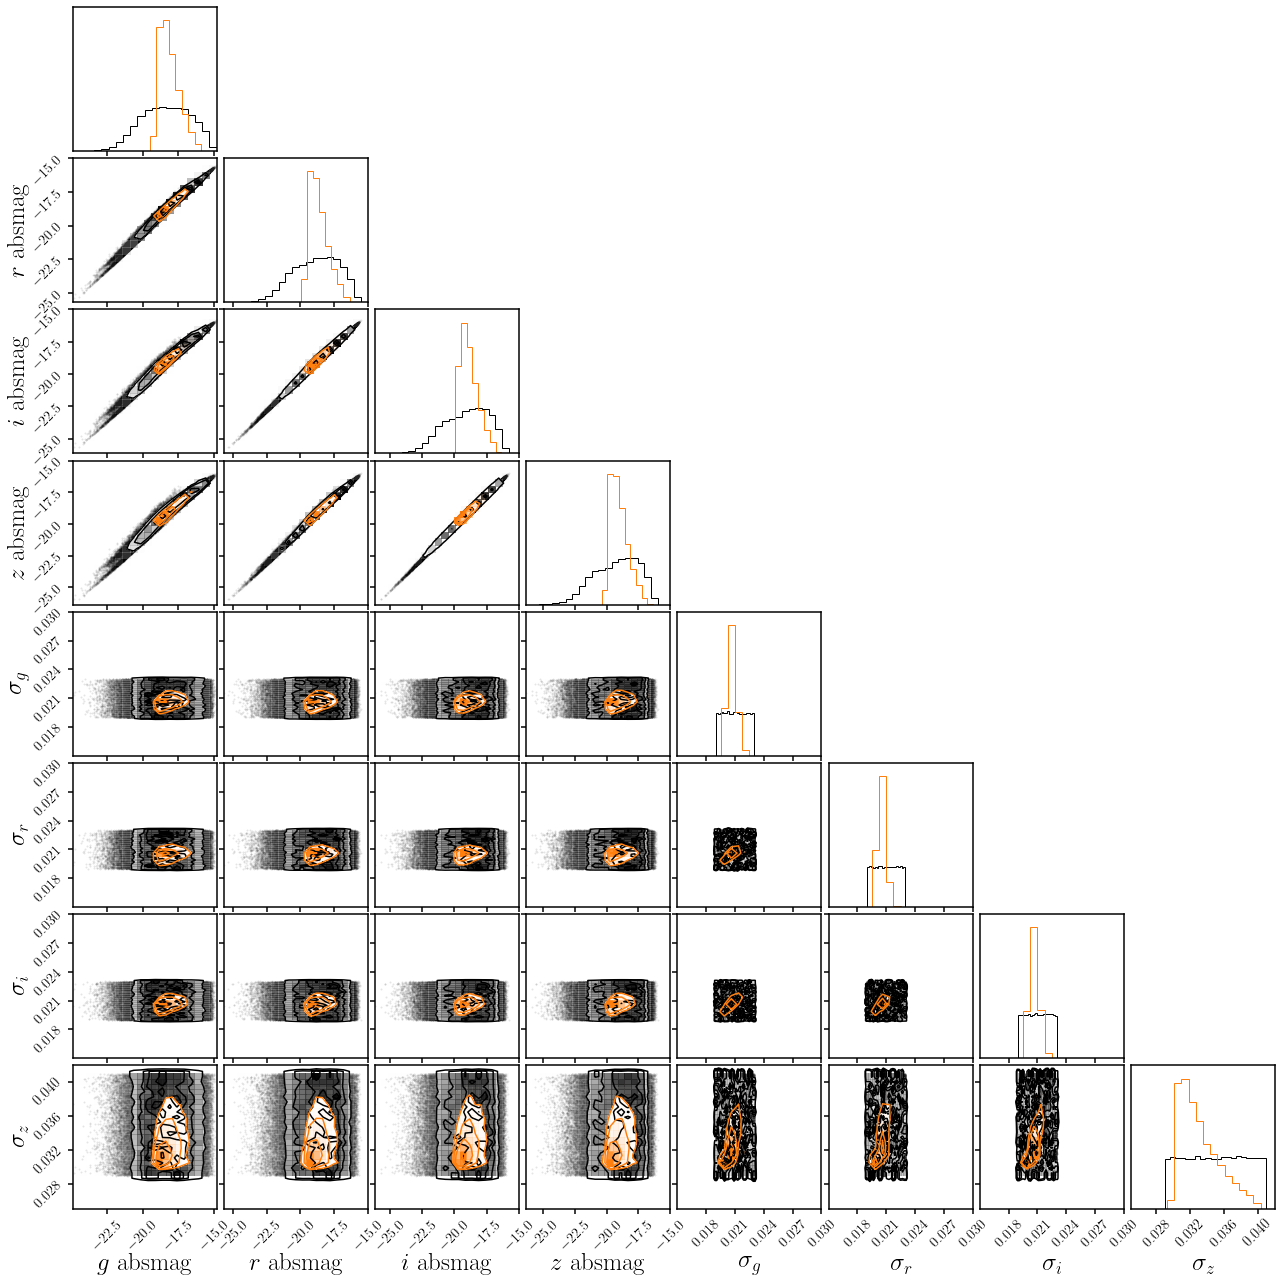

In [21]:
fig = DFM.corner(np.concatenate([absmags_camels, sigma_absmags_camels], axis=1)[::10], color='k', 
                hist_kwargs={'density': True})
_ = DFM.corner(np.concatenate([absmag_nsa, ivar_absmag_nsa**-0.5], axis=1)[cuts & cuts_absmag & cuts_color], color='C1', 
               hist_kwargs={'density': True},
               range=[(-24, -15) for i in range(4)] + [(0.015, 0.03) for i in range(3)] + [(0.025, 0.042)],
               labels=[lbls[i] for i in iobs] + [r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
               label_kwargs={'fontsize': 25}, 
               fig=fig)